# Week 5 Project

### Problem Overview

This Kaggle competition involves modifying stock images to appear in the painting style of Monet in such a way as to 'trick' a discriminator model from being able to tell whether it was generated in the style of Monet or not.

Link to Kaggle Competition: https://www.kaggle.com/competitions/gan-getting-started

### Data Description

We are given 4 folders of images:
- monet_jpg 
- monet_tfrec
- photo_jpg
- photo_tfrec

In [152]:
import os
from matplotlib import pyplot as plt
from matplotlib import image
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

base_data_folder = Path("../input/gan-getting-started/")

monet_jpg_folder = base_data_folder / "monet_jpg"
monet_tfrec_folder = base_data_folder / "monet_tfrec"
photo_jpg_folder = base_data_folder / "photo_jpg"
photo_tfrec_folder = base_data_folder / "photo_tfrec"

## Exploratory Data Analysis

### Data Inspection

In [141]:
# Lets start by taking the size of every image and such

monet_jpg_list = list(monet_jpg_folder.glob("*.jpg"))
monet_tfrec_list = list(monet_tfrec_folder.glob("*.tfrec"))
photo_jpg_list = list(photo_jpg_folder.glob("*.jpg"))
photo_tfrec_list = list(photo_tfrec_folder.glob("*.tfrec"))

print("monet_jpg folder:")
print("number of files: {}".format(len(monet_jpg_list)))
print([str(i) for i in monet_jpg_list[:3]])
print("")

print("monet_tfrec folder:")
print("number of files: {}".format(len(monet_tfrec_list)))
print([str(i) for i in monet_tfrec_list[:3]])
print("")

print("photo_jpg folder:")
print("number of files: {}".format(len(photo_jpg_list)))
print([str(i) for i in photo_jpg_list[:3]])
print("")

print("photo_tfrec folder:")
print("number of files: {}".format(len(photo_tfrec_list)))
print([str(i) for i in photo_tfrec_list[:3]])
print("")


monet_jpg_list_str = [os.path.abspath(str(i)) for i in monet_jpg_list]
photo_jpg_list_str = [os.path.abspath(str(i)) for i in photo_jpg_list]

monet_jpg folder:
number of files: 300
['../input/gan-getting-started/monet_jpg/f4413e97bd.jpg', '../input/gan-getting-started/monet_jpg/7341d96c1d.jpg', '../input/gan-getting-started/monet_jpg/de6f71b00f.jpg']

monet_tfrec folder:
number of files: 5
['../input/gan-getting-started/monet_tfrec/monet12-60.tfrec', '../input/gan-getting-started/monet_tfrec/monet16-60.tfrec', '../input/gan-getting-started/monet_tfrec/monet08-60.tfrec']

photo_jpg folder:
number of files: 7038
['../input/gan-getting-started/photo_jpg/fb97febc5f.jpg', '../input/gan-getting-started/photo_jpg/c54c5368af.jpg', '../input/gan-getting-started/photo_jpg/4a06596662.jpg']

photo_tfrec folder:
number of files: 20
['../input/gan-getting-started/photo_tfrec/photo12-352.tfrec', '../input/gan-getting-started/photo_tfrec/photo11-352.tfrec', '../input/gan-getting-started/photo_tfrec/photo05-352.tfrec']



Ok we can see that in our 4 directories, we have jpegs and also tfrec files respectively. There is a photo and a monet folder for each type of data. There are many more jpegs than there are tfrecs for each category of data.

| Folder       | File Type | Number of Files |
|--------------|-----------|-----------------|
| monet_jpg    | JPEG      | 300             |
| monet_tfrec  | .tfrec    | 5               |
| photo_jpg    | JPEG      | 7038            |
| photo_tfrec  | .tfrec    | 20             |

3|


What is a tfrec file?

See References 1:
https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564

According to the above article .tfrec files are tensorflow's binary file storage format. This allows for the importing of data into the project to be much more efficient for large datasets.
    
Ok, what is in our tfrec files?

In [142]:
print("Counting the images encoded in Monet tfrec files:")
total_images = 0
for file in monet_tfrec_list:
    print(file.stem)
    num_photos = int(file.stem.split("-")[-1])
    total_images+=num_photos
print("# of Images: {}".format(total_images))

print("")
print("Counting the images encoded in Photo tfrec files:")
total_images = 0
for file in photo_tfrec_list:
    print(file.stem)
    num_photos = int(file.stem.split("-")[-1])
    total_images+=num_photos
print("# of Images: {}".format(total_images))

Counting the images encoded in Monet tfrec files:
monet12-60
monet16-60
monet08-60
monet04-60
monet00-60
# of Images: 300

Counting the images encoded in Photo tfrec files:
photo12-352
photo11-352
photo05-352
photo08-352
photo18-352
photo06-352
photo17-352
photo10-352
photo09-352
photo15-352
photo04-352
photo19-350
photo02-352
photo16-352
photo03-352
photo00-352
photo01-352
photo14-352
photo07-352
photo13-352
# of Images: 7038


### Data Visualization

Before we get started on model building it makes sense to look at some visualizations for our data in order to get a better understanding of what we are working with and what the potential pitfalls could be

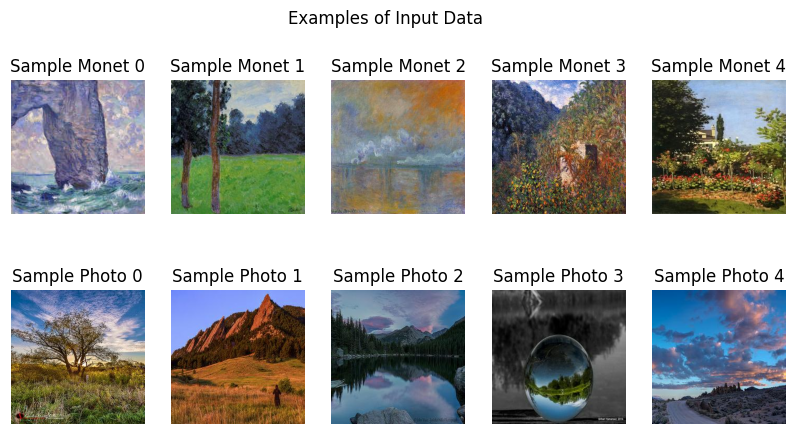

In [143]:
# Lets take a look at the images in each case
np.random.seed(54)

random_indexes = [np.random.randint(0, 300) for i in range(5)]

# Now load the images
monet_image_sample_paths = [monet_jpg_list[i] for i in random_indexes]
photo_image_sample_paths = [photo_jpg_list[i] for i in random_indexes]

fig, axes = plt.subplots(2,5, figsize=(10,5))

axes = axes.flatten()

for iter, ax in enumerate(axes):
    i = iter % 5
    if iter < 5:
        img = image.imread(monet_image_sample_paths[i])
        ax.imshow(img)
        ax.set_title(f"Sample Monet {i}")
        ax.axis('off')
    else:
        img = image.imread(photo_image_sample_paths[i])
        ax.imshow(img)
        ax.set_title(f"Sample Photo {i}")
        ax.axis('off')
fig.suptitle("Examples of Input Data")

plt.show()

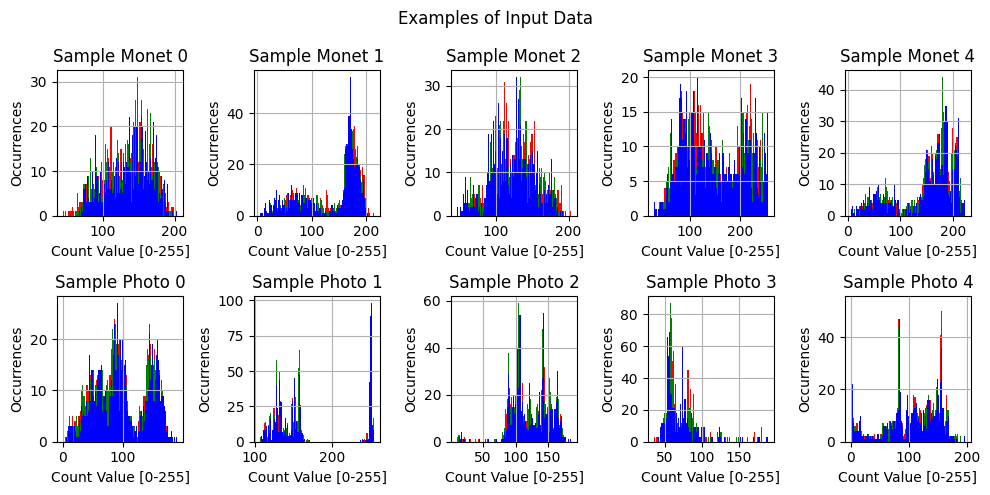

In [144]:
# Also show histograms of the image data
num_bins = 100
fig, axes = plt.subplots(2,5, figsize=(10,5))

axes = axes.flatten()

for iter, ax in enumerate(axes):
    i = iter % 5
    if iter < 5:
        img = image.imread(monet_image_sample_paths[i])
        ax.hist(img[0].flatten(), color = 'red', bins = num_bins)
        ax.hist(img[1].flatten(), color = 'green', bins = num_bins)
        ax.hist(img[2].flatten(), color = 'blue', bins = num_bins)
        ax.set_xlabel("Count Value [0-255]")
        ax.set_ylabel("Occurrences")
        ax.grid()
        # ax.imshow(img)
        ax.set_title(f"Sample Monet {i}")
        # ax.axis('off')
    else:
        img = image.imread(photo_image_sample_paths[i])
        ax.hist(img[0].flatten(), color = 'red', bins = num_bins)
        ax.hist(img[1].flatten(), color = 'green', bins = num_bins)
        ax.hist(img[2].flatten(), color = 'blue', bins = num_bins)
        ax.set_xlabel("Count Value [0-255]")
        ax.set_ylabel("Occurrences")
        ax.grid()
        ax.set_title(f"Sample Photo {i}")
        # ax.axis('off')
fig.suptitle("Examples of Input Data")
fig.tight_layout()

plt.show()

One thing that we can observe from the histograms, is that generally, our images are not saturated, meaning that the data is mostly within 0-255 and not getting cut-off at 255 for any color. Saturation is bad because it reduces the amount of actual data within the image and any features or noise that exists beyond this range is excluded. This could cause problems when training our models, and it is good that this does not seem to be a huge factor in the small image subset that we analyzed.

### View Other Stats About the Images
- Make sure that all of them are of the same dimension, report what that dimension is
- Check the bit depth of all of the images

In [145]:
# Check the size of all images
iter = 0
for img_path in monet_jpg_list:
    img = image.imread(img_path)
    if iter == 0:
        # This is our first image
        imsize = img.shape
        print("Size of the Monet JPG's: {}".format(imsize))
    else:
        assert imsize == img.shape
    iter+=1
print("All Monet Images have the same shape")

print("")
iter = 0
for img_path in photo_jpg_list:
    img = image.imread(img_path)
    if iter == 0:
        # This is our first image
        imsize = img.shape
        print("Size of the Photo JPG's: {}".format(imsize))
    else:
        assert imsize == img.shape
    iter+=1
print("All Photo Images have the same shape")

Size of the Monet JPG's: (256, 256, 3)
All Monet Images have the same shape

Size of the Photo JPG's: (256, 256, 3)
All Photo Images have the same shape


### Data Cleaning and Preparation

So in order to prepare our data for real processing, we will need to do a few things. First, the plan is to use pytorch, so we will need to define a specialized class to handle the loading and 'transformations' on our images. In this 'transformation' step we will apply our data cleaning. 

Our data cleaning just consists of scaling our images to -1 to 1 which is the preferred normalization for GAN style problems

In addition, the pytorch Dataset will allow us to quickly feed in our image data into our model and minimize the burden on RAM for this project, thereby speeding up the process.

In [146]:
from torch.utils.data import Dataset
# Define the pytorch dataset class
class ImageDataset(Dataset):
    """
    Handles the storage of images and makes the loading
    easier for when we have to train our models

    Contains the transform attribute to specify cleaning that is
    to be done to the images
    """
    def __init__(self, image_file_paths, transform = None):
        """
        Set up the class
        """
        assert type(image_file_paths) is list
        assert type(image_file_paths[0]) is str

        self.image_file_paths = image_file_paths
        self.transform = transform


    def __len__(self):
        """
        Needed for the 'DataLoader' step later on
        """
        return len(self.image_file_paths)

    def __getitem__(self, idx):
        """
        Needed for the 'DataLoader' step later on
        Will apply any transromations if specified
        """
        img = Image.open(self.image_file_paths[idx]).convert("RGB")
        if self.transform != None:
            img = self.transform(img)
        return img

In [150]:
# Create all the datasets needed for this project

# First lets define our Datacleaning step:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize the images to save time during training
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Now lets create a couple datasets, one to use for basic warm, up, others for later eval
DATA_CAP_FULL = 300
DATA_CAP_SMALL = 50

monet_dataset_small = ImageDataset(monet_jpg_list_str[:DATA_CAP_SMALL], transform=transform)
photo_dataset_small = ImageDataset(photo_jpg_list_str[:DATA_CAP_SMALL], transform=transform)

monet_loader_small = DataLoader(monet_dataset_small, batch_size=32, shuffle=True)
photo_loader_small = DataLoader(photo_dataset_small, batch_size=32, shuffle=True)

monet_dataset_large = ImageDataset(monet_jpg_list_str[:DATA_CAP_FULL], transform=transform)
photo_dataset_large = ImageDataset(photo_jpg_list_str[:DATA_CAP_FULL], transform=transform)

monet_loader_large = DataLoader(monet_dataset_large, batch_size=32, shuffle=True)
photo_loader_large = DataLoader(photo_dataset_large, batch_size=32, shuffle=True)

### EDA Conclusion - Plan of Analysis

Based on the EDA we can form a plan of analysis to build our best model.

Plan:
- Create a MVP - Minimum Viable Product
- Try a Larger Sized Model (more layers, depth than MVP)
- Try a faster learning rate based on MVP

  
## Model Architecture

### Start with MVP

In [177]:
# Create our Generator
class MVPGenerator(nn.Module):
    """
    Basic Generator Build
    """
    def __init__(self):
        super(MVPGenerator, self).__init__()
        # Define the architecture of the model
        self.model = nn.Sequential(
            # Handle the downscaling part
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(.2),

            # Handle the Upscaling part
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Create our Discriminator
class MVPDiscriminator(nn.Module):
    """
    Basic Discriminator Build
    """
    def __init__(self):
        super(MVPDiscriminator, self).__init__()
        # Define the architecture of the model
        self.model = nn.Sequential(
            # This one is all downscaling
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 1),
            # Use Sigmoid for binary classification, real or fake
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [210]:
def training_loop(device, epochs, monet_loader, photo_loader, disc, genny, loss_fn, disc_opt, genny_opt):
    """
    Handle the training
    """
    disc_losses= []
    genny_losses = []

    for epoch in range(epochs):
        for real_monet, real_photo in zip(monet_loader, photo_loader):
            # Load to our device, keep in memory
            real_monet = real_monet.to(device)
            real_photo = real_photo.to(device)

            # Start with the discriminator
            disc.zero_grad()
            real_labels = torch.ones(real_monet.size(0), 1).to(device)
            fake_labels = torch.zeros(real_monet.size(0), 1).to(device)

            predictions = disc(real_monet)
            disc_loss_real = loss_fn(predictions, real_labels)

            fake_images = genny(real_photo) # generates a set of size batch
            predictions = disc(fake_images.detach())
            disc_loss_fake = loss_fn(predictions, fake_labels)

            disc_loss_total = disc_loss_fake+disc_loss_real
            disc_loss_total.backward()
            disc_opt.step()

            # Now do the generator
            genny.zero_grad()
            predictions = disc(fake_images.detach())
            genny_loss = loss_fn(predictions, real_labels)

            genny_loss.backward()
            genny_opt.step()
        
        # Summary of epoch
        print("Epoch {} : disc_loss: {} genny loss: {}".format(epoch+1, round(disc_loss_total.item(),3), round(genny_loss.item(),3)))
        disc_losses.append(disc_loss_total.item())
        genny_losses.append(genny_loss.item())
    print("Complete")
    return disc_losses, genny_losses

In [211]:
DEVICE = 'cpu'
LEARNING_RATE = .0001
EPOCHS = 50
generator = MVPGenerator().to(DEVICE)
discriminator = MVPDiscriminator().to(DEVICE)

loss_fn = nn.BCELoss()
genny_opt = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_opt = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

disc_losses, genny_losses = training_loop(
    DEVICE,
    EPOCHS,
    monet_loader_small,
    photo_loader_small,
    discriminator,
    generator,
    loss_fn,
    disc_opt,
    genny_opt,
)

Epoch 1 : disc_loss: 0.808 genny loss: 1.98
Epoch 2 : disc_loss: 0.236 genny loss: 3.038
Epoch 3 : disc_loss: 0.083 genny loss: 3.762
Epoch 4 : disc_loss: 0.051 genny loss: 4.086
Epoch 5 : disc_loss: 0.036 genny loss: 4.402
Epoch 6 : disc_loss: 0.025 genny loss: 4.68
Epoch 7 : disc_loss: 0.02 genny loss: 4.877
Epoch 8 : disc_loss: 0.019 genny loss: 5.038
Epoch 9 : disc_loss: 0.016 genny loss: 5.014
Epoch 10 : disc_loss: 0.017 genny loss: 5.485
Epoch 11 : disc_loss: 0.016 genny loss: 5.424
Epoch 12 : disc_loss: 0.01 genny loss: 5.543
Epoch 13 : disc_loss: 0.012 genny loss: 5.452
Epoch 14 : disc_loss: 0.009 genny loss: 6.03
Epoch 15 : disc_loss: 0.009 genny loss: 5.933
Epoch 16 : disc_loss: 0.006 genny loss: 6.141
Epoch 17 : disc_loss: 0.005 genny loss: 6.212
Epoch 18 : disc_loss: 0.007 genny loss: 6.164
Epoch 19 : disc_loss: 0.005 genny loss: 6.24
Epoch 20 : disc_loss: 0.004 genny loss: 6.716
Epoch 21 : disc_loss: 0.005 genny loss: 6.234
Epoch 22 : disc_loss: 0.003 genny loss: 6.621
Epo

Text(0, 0.5, 'BCE Loss')

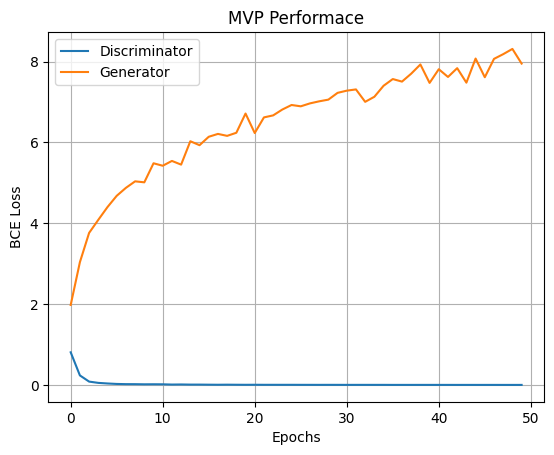

In [212]:
xs = [i for i in range(EPOCHS)]
plt.plot(xs, disc_losses)
plt.plot(xs, genny_losses)
plt.grid()
plt.title("MVP Performace")
plt.legend(["Discriminator", "Generator"])
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")

### Architecture Adjustment: Try a larger model

In [213]:
# Create our Generator
class LargeGenerator(nn.Module):
    """
    Basic Generator Build
    """
    def __init__(self):
        super(LargeGenerator, self).__init__()
        # Define the architecture of the model
        self.model = nn.Sequential(
            # Handle the downscaling part
            nn.Conv2d(3, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(.2),

            # Handle the Upscaling part
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Create our Discriminator
class LargeDiscriminator(nn.Module):
    """
    Basic Discriminator Build
    """
    def __init__(self):
        super(LargeDiscriminator, self).__init__()
        # Define the architecture of the model
        self.model = nn.Sequential(
            # This one is all downscaling
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 1),
            # Use Sigmoid for binary classification, real or fake
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [215]:
DEVICE = 'cpu'
LEARNING_RATE = .0001
EPOCHS = 50
generator = LargeGenerator().to(DEVICE)
discriminator = LargeDiscriminator().to(DEVICE)

loss_fn = nn.BCELoss()
genny_opt = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_opt = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

disc_losses_large, genny_losses_large = training_loop(
    DEVICE,
    EPOCHS,
    monet_loader_small,
    photo_loader_small,
    discriminator,
    generator,
    loss_fn,
    disc_opt,
    genny_opt,
)

Epoch 1 : disc_loss: 0.887 genny loss: 1.774
Epoch 2 : disc_loss: 0.253 genny loss: 2.743
Epoch 3 : disc_loss: 0.122 genny loss: 3.706
Epoch 4 : disc_loss: 0.081 genny loss: 3.831
Epoch 5 : disc_loss: 0.071 genny loss: 3.937
Epoch 6 : disc_loss: 0.039 genny loss: 4.114
Epoch 7 : disc_loss: 0.031 genny loss: 4.549
Epoch 8 : disc_loss: 0.021 genny loss: 4.863
Epoch 9 : disc_loss: 0.026 genny loss: 4.758
Epoch 10 : disc_loss: 0.017 genny loss: 5.11
Epoch 11 : disc_loss: 0.015 genny loss: 5.145
Epoch 12 : disc_loss: 0.014 genny loss: 5.299
Epoch 13 : disc_loss: 0.014 genny loss: 5.345
Epoch 14 : disc_loss: 0.011 genny loss: 5.454
Epoch 15 : disc_loss: 0.009 genny loss: 5.768
Epoch 16 : disc_loss: 0.009 genny loss: 5.619
Epoch 17 : disc_loss: 0.009 genny loss: 5.669
Epoch 18 : disc_loss: 0.01 genny loss: 5.964
Epoch 19 : disc_loss: 0.008 genny loss: 5.801
Epoch 20 : disc_loss: 0.006 genny loss: 6.017
Epoch 21 : disc_loss: 0.006 genny loss: 6.116
Epoch 22 : disc_loss: 0.005 genny loss: 5.998

Text(0, 0.5, 'BCE Loss')

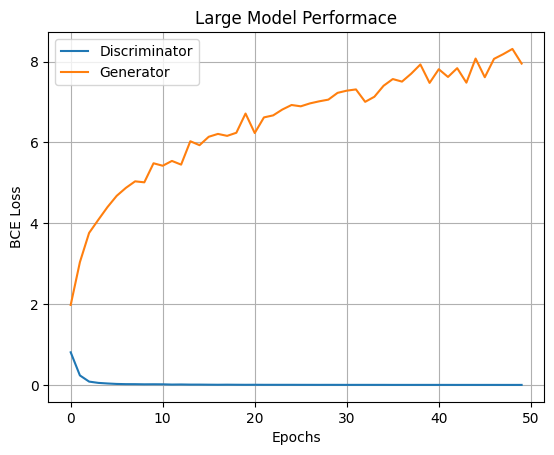

In [216]:
xs = [i for i in range(EPOCHS)]
plt.plot(xs, disc_losses_large)
plt.plot(xs, genny_losses_large)
plt.grid()
plt.title("Large Model Performace")
plt.legend(["Discriminator", "Generator"])
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")

### Hyperparameter Tuning: Adjust Learning Rate

In [218]:
DEVICE = 'cpu'
LEARNING_RATE = .00001
EPOCHS = 50
generator = LargeGenerator().to(DEVICE)
discriminator = LargeDiscriminator().to(DEVICE)

loss_fn = nn.BCELoss()
genny_opt = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_opt = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

disc_losses_slow, genny_losses_slow = training_loop(
    DEVICE,
    EPOCHS,
    monet_loader_small,
    photo_loader_small,
    discriminator,
    generator,
    loss_fn,
    disc_opt,
    genny_opt,
)

Epoch 1 : disc_loss: 1.35 genny loss: 0.781
Epoch 2 : disc_loss: 1.195 genny loss: 0.939
Epoch 3 : disc_loss: 1.058 genny loss: 1.043
Epoch 4 : disc_loss: 0.989 genny loss: 1.058
Epoch 5 : disc_loss: 0.825 genny loss: 1.234
Epoch 6 : disc_loss: 0.763 genny loss: 1.278
Epoch 7 : disc_loss: 0.713 genny loss: 1.392
Epoch 8 : disc_loss: 0.568 genny loss: 1.445
Epoch 9 : disc_loss: 0.515 genny loss: 1.585
Epoch 10 : disc_loss: 0.507 genny loss: 1.662
Epoch 11 : disc_loss: 0.434 genny loss: 1.781
Epoch 12 : disc_loss: 0.432 genny loss: 1.798
Epoch 13 : disc_loss: 0.404 genny loss: 1.821
Epoch 14 : disc_loss: 0.39 genny loss: 1.92
Epoch 15 : disc_loss: 0.337 genny loss: 2.057
Epoch 16 : disc_loss: 0.349 genny loss: 2.13
Epoch 17 : disc_loss: 0.29 genny loss: 2.15
Epoch 18 : disc_loss: 0.285 genny loss: 2.211
Epoch 19 : disc_loss: 0.214 genny loss: 2.327
Epoch 20 : disc_loss: 0.228 genny loss: 2.387
Epoch 21 : disc_loss: 0.201 genny loss: 2.467
Epoch 22 : disc_loss: 0.244 genny loss: 2.395
Epo

Text(0, 0.5, 'BCE Loss')

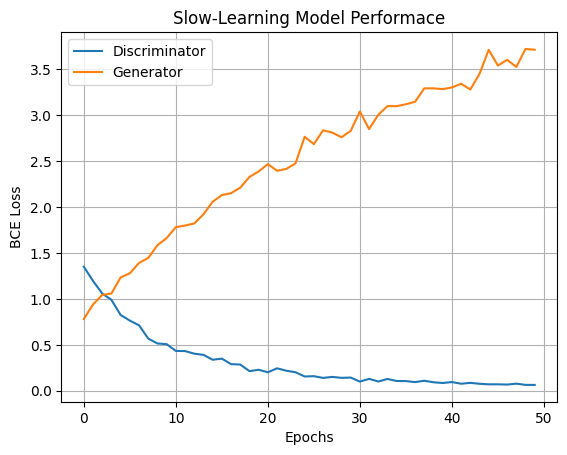

In [220]:
xs = [i for i in range(EPOCHS)]
plt.plot(xs, disc_losses_slow)
plt.plot(xs, genny_losses_slow)
plt.grid()
plt.title("Slow-Learning Model Performace")
plt.legend(["Discriminator", "Generator"])
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")

## Results and Analysis

| Model        | Ending Discriminator Loss | Ending Generator Loss |
|--------------|-----------|-----------------|
| mvp    | .001      | 7.592             |
| large  | .001    | 7.562               |
| slow    | 0.063    | 3.712            |

Our models did not converge. In all cases there was no sign that the models were approaching convergence. That being said, there really was no significant difference between the mvp and the more complex model. In the case of reducing the learning rate, this seemed to make the model more stable but the same faulty trends were present.

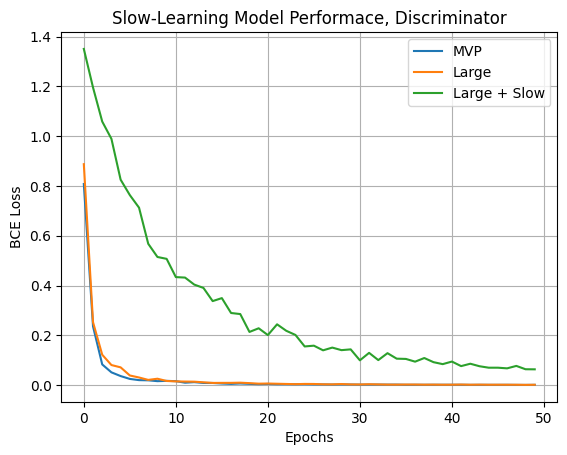

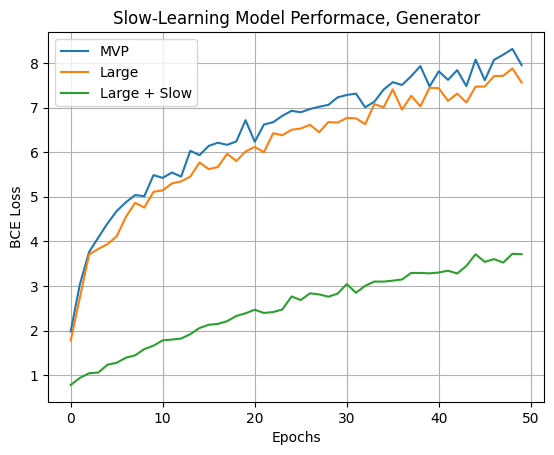

In [219]:
xs = [i for i in range(EPOCHS)]
plt.plot(xs, disc_losses)
plt.plot(xs, disc_losses_large)
plt.plot(xs, disc_losses_slow)
plt.grid()
plt.title("Slow-Learning Model Performace, Discriminator")
plt.legend(["MVP", "Large", "Large + Slow"])
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.show()

plt.plot(xs, genny_losses)
plt.plot(xs, genny_losses_large)
plt.plot(xs, genny_losses_slow)
plt.grid()
plt.title("Slow-Learning Model Performace, Generator")
plt.legend(["MVP", "Large", "Large + Slow"])
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.show()

## Conclusion

In this project Exploratory Data Analysis on the input data from Kaggle. From that a plan was constructed for the building of our Deep Learning models. Then an MVP was constructed using pytorch. From this, a larger architecture was conceived as well as a slower learning rate was used in order to tune hyperparameters. Finally the performance of these models were compaired. 

The performance ofthese models were quite bad. In all cases, there was no hint at the models converging. It is unclear if the models needed more training time, more samples, or the architecture or the learning rate was insufficient. There needs to be more investigation done in order to determine the cause of this poor performance.

### Learnings and Takeaways

During this project I learned the basics of setting up NN models using Pytorch, which is something we have not used before in our class. I enjoyed learning about and using Pytorch more than tensorflow, which is what we have been using in the past. I found Pytorch faster to set up, more intuitive and easier to debug than tensorflow.

### What helped and didn't help

What helped:
- Switching from tensorflow to pytorch really helped speed up development
- Using a truncated dataset helped to speed up the performance of the model so I could learn more about using pytorch

What didn't help:
- using truncated data may have worsened the performance of our model

### What could be done differently for next time
- Try to incorporate all photo images instead of a subset that matches the number of Monet images
- Try different learning rates from the discriminator and the generator
- Try using cycle GAN instead of just GAN
- Try using PatchGAN

## References

Gamauf, T. (2018, March 20). TensorFlow records: What they are and how to use them. Medium. https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564
